# Analyse Experiment Data

With pressure sensor parascientific and new speaer 

In [1]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
config = {}

In [3]:
config['datapath_femto'] = "/home/andbro/Documents/ROMY/Scripps_Fiber/data/experiments/"

st = obs.read(config['datapath_femto']+"munki1.262.263.css.wfdisc", format="CSS")
st.merge()
st[0].stats.calib = 1.0
st

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/core/trace.py:220: UserWarning: Calibration factor set to 0.0!
  warnings.warn(msg, UserWarning)


1 Trace(s) in Stream:
.munki1..p1s32 | 2022-09-18T23:43:50.069720Z - 2022-09-20T22:12:26.019720Z | 20.0 Hz, 3346320 samples

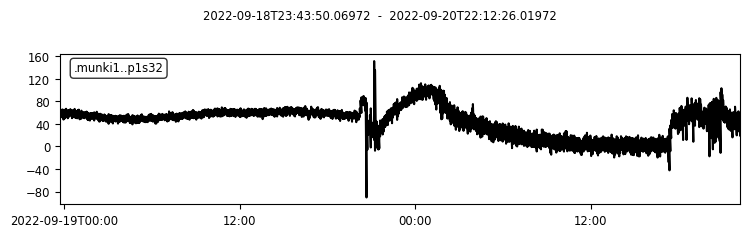

In [4]:
st.plot(equal_scale=False);

## Experiment Valve Open

Read pressure data

In [5]:
config['datapath_pressure'] = "/home/andbro/Documents/ROMY/Scripps_Fiber/data/pressure/"

In [6]:
## read data of parascientific barometer
pressure = pd.read_csv(config['datapath_pressure']+"DATA2.txt", names=["timestamp","pressure"])

## convert timestamp to datetime objects
pressure['timestamp'] = pd.to_datetime(pressure.timestamp)

## make local time to UTC (+7 hours)
pressure['timestamp'] += pd.to_timedelta(7, unit='h')

## resample with df=1sec
pressure = pressure.resample("1S", on="timestamp").mean().reset_index()

pressure

,timestamp,pressure
0,2022-09-20 01:52:34,100.979900
1,2022-09-20 01:52:35,101.096000
2,2022-09-20 01:52:36,100.981200
3,2022-09-20 01:52:37,100.719250
4,2022-09-20 01:52:38,100.490500
...,...,...
55563,2022-09-20 17:18:37,101.151033
55564,2022-09-20 17:18:38,101.367650
55565,2022-09-20 17:18:39,101.351100
55566,2022-09-20 17:18:40,101.118200


In [7]:
pressure_trace = obs.Trace()

pressure_trace.data = np.array(pressure.pressure)
pressure_trace.stats.starttime = obs.UTCDateTime(pressure.timestamp[0])
pressure_trace.stats.delta = 1.0
pressure_trace.stats.station = "BARO"
pressure_trace.stats.channel = "XXX"

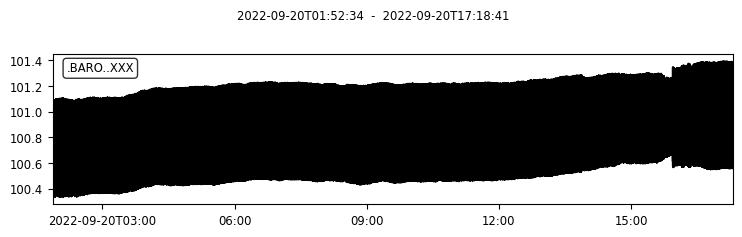

In [8]:
pressure_trace.plot();

Text(0, 0.5, 'Pressure (kPa)')

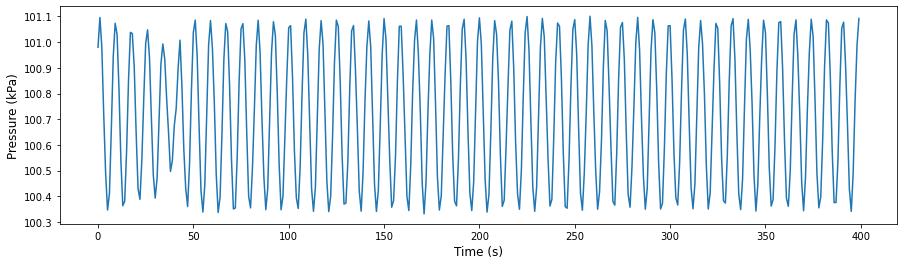

In [9]:
plt.figure(figsize=(15,4))
plt.plot(pressure_trace.data[:400])
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Pressure (kPa)", fontsize=12)

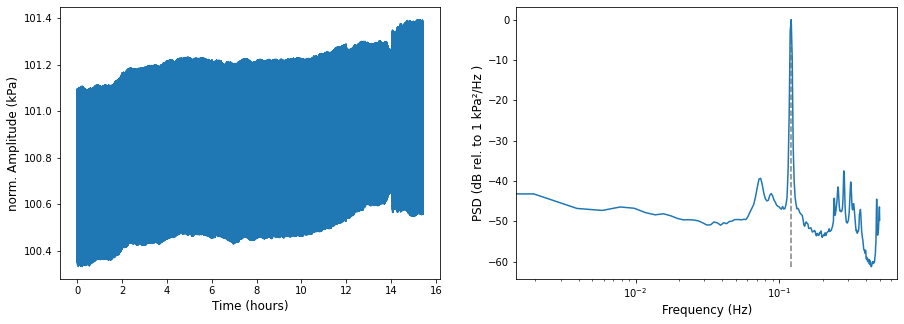

In [109]:
def __plot_psd(trace):

    from scipy.signal import welch, hann


    signal = trace.data 

    nblock =  512
    overlap = None
    # window = hann(int(nblock))

    f, Pxx = welch(signal, fs=trace.stats.sampling_rate, 
                    window='hann', noverlap=overlap, nperseg=nblock,
                    scaling="density",
                    return_onesided=True)
    ## normalize
    # Pxx /= nblock

    Pxx /= max(Pxx)
    Pxx = 10*np.log10(Pxx)


    ## ------------------------

    font = 12

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    tx = np.linspace(0, trace.stats.npts/trace.stats.sampling_rate/3600, trace.stats.npts)
    ax[0].plot(tx, signal)

    ax[1].vlines(0.120, min(Pxx), max(Pxx), color="grey", ls="--", alpha=1, zorder=0)
    ax[1].semilogx(f, Pxx)

#     ax[1].set_ylim(-80,5)
#     ax[1].set_xlim(1e-3,5)

    ax[0].set_xlabel("Time (hours)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[0].set_ylabel("norm. Amplitude (kPa)", fontsize=font)
    ax[1].set_ylabel("PSD (dB rel. to 1 kPa²/Hz )", fontsize=font)

    plt.show();
    
__plot_psd(pressure_trace)

2022-09-20T01:52:34.000000Z 2022-09-20T17:18:41.000000Z


Text(0, 0.5, 'Phase (rad)')

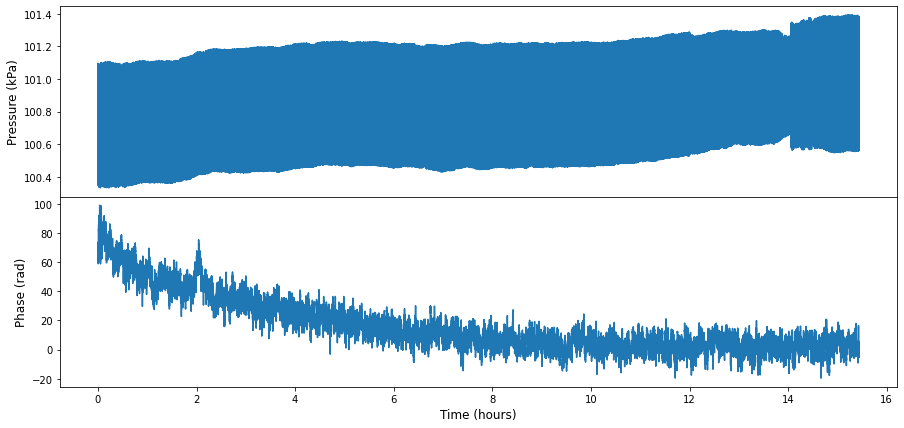

In [108]:
st2 = st.copy()

## cut to pressure record
tbeg, tend = obs.UTCDateTime(pressure.timestamp[0]), obs.UTCDateTime(pressure.timestamp[len(pressure.timestamp)-1])
print(tbeg, tend)
st2.trim(tbeg, tend)

## add pressure trace
st2 += pressure_trace


# st2.plot(equal_scale=False);


fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)

fig.subplots_adjust(hspace=0)

ax[0].plot(st2.select(station="BARO")[0].times()/3600, st2.select(station="BARO")[0].data)
ax[1].plot(st2.select(station="munki1")[0].times()/3600, st2.select(station="munki1")[0].data)

plt.xlabel("Time (hours)", fontsize=12)
ax[0].set_ylabel("Pressure (kPa)", fontsize=12)
ax[1].set_ylabel("Phase (rad)", fontsize=12)


In [12]:

# st2.detrend('polynomial', order=2)
# st2.detrend('simple')

# st2.taper(0.1)
# st2.filter('highpass', freq=0.1, corners=4, zerophase=True)

# st2.plot(equal_scale=False);

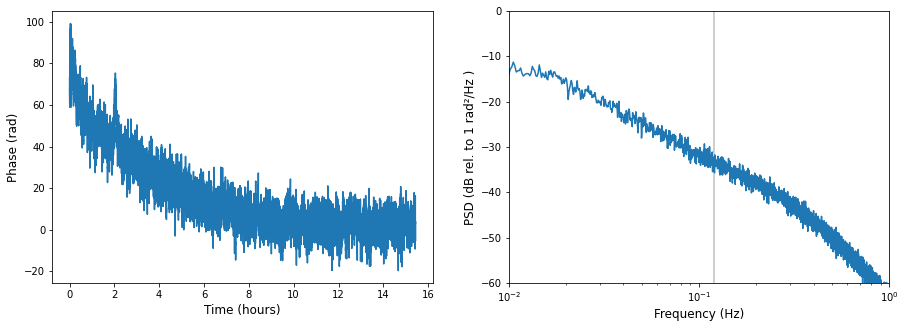

In [107]:
def __plot_psd(trace):

    from scipy.signal import welch, hann


    signal = trace.data

    nblock =  512 *200
    overlap = None
    # window = hann(int(nblock))

    f, Pxx = welch(signal, fs=trace.stats.sampling_rate, 
                    window='hann', noverlap=overlap, nperseg=nblock,
                    scaling="density",
                    return_onesided=True)
    ## normalize
    # Pxx /= nblock

    Pxx /= max(Pxx)
    Pxx = 10*np.log10(Pxx)


    ## ------------------------

    font = 12

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    tx = np.linspace(0, trace.stats.npts/trace.stats.sampling_rate/3600, trace.stats.npts)
    ax[0].plot(tx, signal)

    ax[1].vlines(0.120, min(Pxx), max(Pxx), color="grey", ls="-", alpha=0.5, zorder=0)
    ax[1].semilogx(f, Pxx)

    ax[1].set_ylim(-60,0)
    ax[1].set_xlim(1e-2,1)

    ax[0].set_xlabel("Time (hours)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[0].set_ylabel("Phase (rad)", fontsize=font)
    ax[1].set_ylabel("PSD (dB rel. to 1 rad²/Hz )", fontsize=font)

    plt.show();
    
__plot_psd(st2.select(station="munki1")[0])

In [14]:
def __rms_power(Pxx, f):
   
    rxx = [np.sqrt(abs(Pxx[n+1]-Pxx[n]) * abs(f[n+1]-f[n])) for n in range(len(Pxx)-1)]
    
    return rxx, f[:-1]

rxx, ff = __rms_power(Pxx, f)

plt.loglog(ff, rxx)
plt.loglog(f, Pxx * f)

NameError: name 'Pxx' is not defined

## CrossCorrelate

In [42]:
from andbro__crosscorrelation import __crosscorrelation

In [65]:
st4 = st2.copy()

st4.detrend("polynomial", order=2)
# st4.merge(fill_value='interpolate')

st4.resample(1.0)

st4.taper(0.1)

st4.filter("bandpass", freqmin=0.12-0.4, freqmax=0.12+0.4, corners=4, zerophase=True)

st4.plot(equal_scale=False);

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (0.52) of bandpass is at or above Nyquist (0.5). Applying a high-pass instead.
  warnings.warn(msg)


ValueError: Digital filter critical frequencies must be 0 < Wn < 1

487


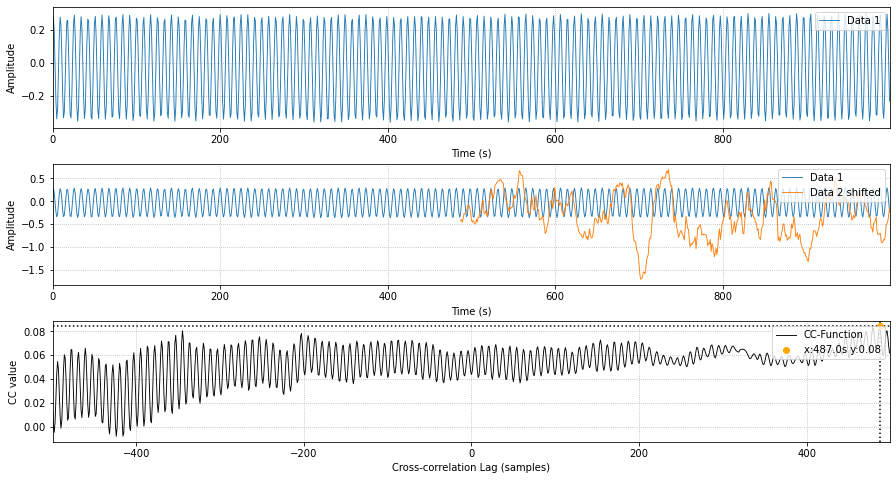

Maximum Correlation: 
 x: 487 
 y: 0.08


In [73]:
sig1 = st4.select(station="BARO")[0].data[5000:6000]
sig2 = st4.select(station="munki1")[0].data[5000:6000]

out = __crosscorrelation(sig1, sig2, deltaT=st4[0].stats.delta)

##  Test PSD

In [ ]:
aa = [1,.5,6,.5,4]
ff = [0.1, 1, 4,8,2]
phi = [0.2, 0.7, 1.1, 3.0, 2]

aa = [.3,.6]
ff = [1,5]
phi = [1,2]


dt = 1/20
tt = np.arange(0,200,dt)

sig = np.zeros(len(tt))
for a,f,p in zip(aa, ff, phi):
    sig += a * np.sin(2*np.pi*f*tt+p)

plt.plot(sig)

In [ ]:
nblock =  512
overlap = None
win = hann(nblock, True)

f, Pxx = welch(sig, fs=1/dt, 
                window='hann', noverlap=overlap, nperseg=nblock,
                scaling="density",
                return_onesided=True)


plt.plot(f, Pxx)
plt.plot(f, np.sqrt(Pxx*f))

# plt.vlines(ff, 0, max(Pxx), color="grey", zorder=-1)
plt.vlines(ff, 0, aa, color="red", zorder=-1)

In [ ]:
N = len(Pxx)-1

new = np.zeros(N)
for n in range(N):
    new[n] = np.sqrt(abs(Pxx[n+1]-Pxx[n]) * abs(f[n+1]-f[n]))
    
plt.semilogx(f[:-1], new)